# Recurrent neural network

__Author:__ John Leung

__Content:__ This program demonstrates the tasks of natural language processing and sequence sampling using recurrent neural networks (RNNs) in the keras framework. In particular, we construct our many-to-many RNN using networks of Long Short Term Memory (LSTM) blocks.

In the first part of the program, we translate French sentences to a English sentences. The sample sentences we use by default are drawn from a French congressional debate in https://www.isi.edu/natural-language/download/hansard/. The model is an RNN with attention. we use is as follow: First (after tokenization and conversion to index-representation) we decode the French sentences using a bi-directional LSTM (Bi-LSTM). The information decoded by this pre-attention Bi-LSTM is then passed onto the attention layer. The attention layer consists of units of neurons. Finally, its output is read by another (post-attention) LSTM to generate an output sequence of our desired English sentences. The important feature of this attention network is that the output sequence is of a length different from the input sequence.

In the second part of the program, we synthesize English sentences by sampling a trained RNN. We first train a LSTM RNN to identify English sentences from the same extracts from congressional debate. The RNN accepts an input of word x(t), at position t, and outputs a prediction of the next word y=x(t+1). After training the model, we intialize the trained RNN by a random/zero input x(t=0). Then at every time step we fit the LSTM input with the previous time step x(t)=y(t-1). This way we sample the model and synthesize a new sequence using only the model and a single initialization time step as inputs.

This program is inspired by and use data source from the course on [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) provided by __deeplearning.ai__ on __Coursera__.

In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function

import IPython
import tensorflow as tf
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda, Dropout, Reshape
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.models import load_model, Model
from tensorflow.python.keras import backend as tf_keras_backend
import keras.backend as K
import numpy as np
from tqdm import tqdm_notebook

import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk
import codecs
from copy import deepcopy

nltk_dir = '/Users/nltk_data'
data_dir = 'data/hansard.36/Release-2001.1a/sentence-pairs/house/debates/development/'
tknzr = nltk.tokenize.TweetTokenizer()
en_sentence_detector = nltk.data.load(nltk_dir + '/tokenizers/punkt/english.pickle')
fr_sentence_detector = nltk.data.load(nltk_dir + '/tokenizers/punkt/french.pickle')

%matplotlib inline

Using TensorFlow backend.


A module that creates a dictionary for the words appeared in the sample. It also converts sample of sentences to tokenized words in index representation corresponding to a dictionary it creates. The module was taken from https://pythonhealthcare.org/2018/12/20/108-converting-text-to-numbers/ and modified for our use.

In [2]:
def text_to_indices(text, cutoff_for_rare_words = 1):
    
    # Flatten list if sublists are present
    if len(text) > 1:
        flat_text = [item for sublist in text for item in sublist]
    else:
        flat_text = text
    
    # get word freuqncy
    fdist = nltk.FreqDist(flat_text)

    # Convert to Pandas dataframe
    df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
    df_fdist.columns = ['Frequency']

    # Sort by word frequency
    df_fdist.sort_values(by=['Frequency'], ascending=False, inplace=True)

    # Add word index
    number_of_words = df_fdist.shape[0]
    df_fdist['word_index'] = list(np.arange(number_of_words)+1)

    # replace rare words with index zero
    frequency = df_fdist['Frequency'].values
    word_index = df_fdist['word_index'].values
    mask = frequency <= cutoff_for_rare_words
    word_index[mask] = 0
    df_fdist['word_index'] =  word_index
    
    # Convert pandas to dictionary
    word_dict = df_fdist['word_index'].to_dict()
    word_dict.update({u"<unk>":0})
    pad_num = max(word_dict.values()) + 1
    word_dict.update({u"<pad>":pad_num})
    reversed_dict = {value : key for (key, value) in word_dict.items()}
    reversed_dict.update({0:u"<unk>"})
    
    # Use dictionary to convert words in text to numbers
    text_numbers = []
    for string in text:
        string_numbers = [word_dict[word] for word in string]
        text_numbers.append(string_numbers)

    return word_dict, reversed_dict, text_numbers

Extracting sentences from the congressional debate. We filter sentences that are too short, or not meaningful (such as those calling the names of particular congresspersons). We print two sample sentences, one from English and the other from French, and see how it goes through the preprocess pipline.

In [3]:
read_length = 8000
num_len = 3; first_file = 1; last_file = 243
file_char_encoding = 'cp1252'
len_cut = 30

train_set = 'training/hansard.36.1.house.debates.'

sentence_sample = np.random.randint(read_length)

current_len = 0
en_text = []; fr_text = []
for file_no in range(first_file, last_file+1):
    filename_e = data_dir + train_set + str(file_no).zfill(num_len) + '.e'
    filename_f = data_dir + train_set + str(file_no).zfill(num_len) + '.f'
    f_en = codecs.open(filename_e, "r", encoding=file_char_encoding)
    f_fr = codecs.open(filename_f, "r", encoding=file_char_encoding)
    while True:
        line_e = f_en.readline()
        line_f = f_fr.readline()
        if (not line_e) or (not line_f): break
        en_line = (line_e.encode('utf-8')).strip().lower()
        fr_line = (line_f.encode('utf-8')).strip().lower()
        #-----------------------------------------
        if (len(fr_line) < len_cut):
            continue
        if (fr_line[:2]=='* ') or (fr_line[:3]=='m. ') or (fr_line[:4]=='mme ') or (fr_line[:7]=='l\'hon. '):
            continue
        if (fr_line[-1]==':'):
            continue
        #-----------------------------------------
        en_text.append(en_line)
        fr_text.append(fr_line)
        current_len = current_len + 1
        if current_len >= read_length:
            break
    f_en.close()
    f_fr.close()
    if current_len >= read_length:
            break

print(en_text[sentence_sample])
print(fr_text[sentence_sample])

mr. speaker, the citizens of windsor and essex county raised concerns about not getting timely and accurate warnings of severe weather conditions.
monsieur le président, les habitants de windsor et du comté d'essex ont soulevé des préoccupations parce qu'ils ne reçoivent pas des avertissements précis et à temps au sujet de graves conditions atmosphériques.


Tokenizing all the words in the sentences of the samples.

In [4]:
en_token = []; fr_token = [];
for s in tqdm_notebook(en_text):
    en_token.append( tknzr.tokenize(s.strip()) )
for s in tqdm_notebook(fr_text):
    fr_token.append(tknzr.tokenize(s.strip()) )
    
del en_text; del fr_text;
    
print(en_token[sentence_sample])
print('\n')
print(fr_token[sentence_sample])


[u'mr', u'.', u'speaker', u',', u'the', u'citizens', u'of', u'windsor', u'and', u'essex', u'county', u'raised', u'concerns', u'about', u'not', u'getting', u'timely', u'and', u'accurate', u'warnings', u'of', u'severe', u'weather', u'conditions', u'.']


[u'monsieur', u'le', u'pr\xe9sident', u',', u'les', u'habitants', u'de', u'windsor', u'et', u'du', u'comt\xe9', u"d'essex", u'ont', u'soulev\xe9', u'des', u'pr\xe9occupations', u'parce', u"qu'ils", u'ne', u're\xe7oivent', u'pas', u'des', u'avertissements', u'pr\xe9cis', u'et', u'\xe0', u'temps', u'au', u'sujet', u'de', u'graves', u'conditions', u'atmosph\xe9riques', u'.']


We create dictionaries, one for English and the other for French, for the words appeared in the sample. Then we convert the word token lists to their index representations that correspond to the dictionaries we created.

In [5]:
en_2_ind, ind_2_en, en_indices = text_to_indices(en_token, cutoff_for_rare_words=0)
fr_2_ind, ind_2_fr, fr_indices = text_to_indices(fr_token, cutoff_for_rare_words=0)

print(en_indices[sentence_sample])
print(fr_indices[sentence_sample])

[28, 2, 32, 4, 1, 206, 5, 1036, 6, 3248, 1332, 1157, 406, 56, 25, 616, 2662, 6, 3492, 6401, 5, 2608, 3058, 1454, 2]
[35, 4, 32, 2, 6, 276, 1, 1076, 7, 11, 550, 3646, 38, 4796, 9, 645, 171, 91, 30, 1486, 26, 9, 12098, 1205, 7, 8, 136, 18, 245, 1, 1414, 922, 4509, 3]


# Natural language processing - translating date format

In this section, our task is to translate between human-style date to machine style date.

First and foremost, we read in the data (X, Y). X contains one-hot representation of French sentences, and Y contains those of English sentences.

To achieve the goal of translation, we need a dictionary that maps words to indices, which contains all the possible words English/French, including the unknown character "`<unk>`" and padding for empty spaces "`<pad>`". We also include inverse dictionaries that maps indices back to words.

## Preprocessing

We convert the data to one-hot representation. We also truncate the input (x) character to Tx (default Tx = 30) characters. Strings longer Tx characters are thrown away and strings shorter than Tx characters are padded to Tx characters.

In [6]:
def preprocess((sents, inds), lang_2_ind, T):
    sents_ret = []; inds_ret = []; inds_ohs = [];
    i = 0;
    for sent in tqdm_notebook(sents):
        ind = inds[i]
        if len(sent) >= T:
            sent_redux = sent[0:T]
            ind_redux = ind[0:T]
        else:
            sent_redux = sent + ['<pad>'] * (T - len(sent))
            ind_redux = ind + [lang_2_ind['<pad>']] * (T - len(ind))
        ind_oh = np.zeros((T, max(lang_2_ind.values())+1 ))
        
        ind_oh[np.arange(T), ind_redux] = 1
        sents_ret.append(sent_redux)
        inds_ret.append(ind_redux)
        inds_ohs.append(ind_oh)
        i = i + 1
    return sents_ret, np.array(inds_ret), np.array(inds_ohs)

In [7]:
Tx = 30
Ty = 30

raw_X, X, Xoh = preprocess((fr_token, fr_indices), fr_2_ind, Tx)
del raw_X; del fr_indices; del fr_token;
raw_Y, Y, Yoh = preprocess((en_token, en_indices), en_2_ind, Ty)
del raw_Y; del en_indices; del en_token;

en_dict_size = max(en_2_ind.values())+1
fr_dict_size = max(fr_2_ind.values())+1


print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)


X.shape: (8000, 30)
Y.shape: (8000, 30)
Xoh.shape: (8000, 30, 13294)
Yoh.shape: (8000, 30, 9484)


## Attention block

This is the model of the attention block. Attention block is a neural network (at each time step of the machie output Bi-LSTM, i.e. the post-attention Bi-LSTM), that accepts the input from the full sequence output of the pre-attention Bi-LSTM and the out from the previous time step of the post-attention LSTM. It outputs what the word of this post-attention LSTM should be.

__1.)__ First, it takes the output of the previous post-attention LSTM block (s_prev) and broadcasts it over fully-connected units in the attention neural network (repeater). __2.)__ Before passing to the NN, the input Tx copies of s_prev is concatenated with the full output sequence of the pre-attention Bi-LSTM, each output time step of the pre-attention Bi-LSTM multiplies a different weight. __3.)__ Each concatenated vector first passes through two fully-connected layers of its own with tanh andrelu as activation. __4.)__ Then all the vectors are join together to pass through the softmax activation. The output "attention weights" (alphas) are the attention the post-attention should pay to each element (a_i) of the pre-attention Bi-LSTM. __5.)__ The "context" to be input to the post-attention LSTM is generated by the dot product between the attention of the pre-attention sequence (alpha dot a).

In [8]:
def softmax(x, axis=1):
    #Arguments
    #    x : Tensor.
    #    axis: Integer, axis along which the softmax normalization is applied.
    #Returns
    #    Tensor, output of softmax transformation.
    #Raises
    #    ValueError: In case `dim(x) == 1`.

    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
    return

In [9]:
repeater = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
FC1 = Dense(10, activation = "tanh")
FC2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

def one_step_attention(a, s_prev):    
    #Arguments:
    #a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    #s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    #Returns:
    #context -- context vector, input of the next (post-attention) LSTM cell

    s_prev = repeater(s_prev)
    concat = concatenator([a,s_prev])
    intermediate_energies = FC1(concat)
    energies = FC2(intermediate_energies)
    alphas = activator(energies)
    context = dotor([alphas,a])
    
    return context

## Post-attention LSTM

Define the post-attention LSTM. The post-attention LSTM with generate a word at each time step that will eventual become the full translated sentence. The states generated by the post-attention LSTM passes through a softmax activator that will output the predicted word.

In [10]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(en_dict_size, activation=softmax)

## Full model

The full model consists of: first the bi-directional LSTM that decodes the human format date, with the sequence output stored at a; then a for-loop that goes through the time steps of the post-attention LSTM, utilizing the attention and the t-1 time step as input to generate a new sequence.

In [11]:
def model(Tx, Ty, n_a, n_s, lang_dict_size, tran_dict_size):

    #Arguments:
    #Tx -- length of the input sequence
    #Ty -- length of the output sequence
    #n_a -- hidden state size of the Bi-LSTM
    #n_s -- hidden state size of the post-attention LSTM
    #human_vocab_size -- size of the python dictionary "human_vocab"
    #machine_vocab_size -- size of the python dictionary "machine_vocab"

    #Returns:
    #model -- Keras model instance
    
    X = Input(shape=(Tx, lang_dict_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
   
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])
        out = output_layer(inputs=s)
        outputs.append(out)
    
    model = Model(inputs=[X,s0,c0], outputs=outputs)

    return model

Compile the model

In [12]:
model = model(Tx, Ty, n_a, n_s, fr_dict_size, en_dict_size)
model.summary()


opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.99, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 13294)    0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       3411712     input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

Fit the model with the data (X,Y).

In [ ]:
m = read_length

pad_weight = 1e-3
unk_wright = 1
weights_list = np.ones(len(ind_2_en))/len(ind_2_en)
weights_list[0] = unk_wright/len(ind_2_en)
weights_list[-1] = pad_weight/len(ind_2_en)
weights_dict = dict(zip(ind_2_en.keys(), weights_list))

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

model_history = model.fit([Xoh, s0, c0], outputs, epochs=1000, batch_size=100, class_weight=weights_dict)
#model_history = model.fit([Xoh, s0, c0], outputs, epochs=500, validation_split=0.2, batch_size=100,\
#                      shuffle=True, class_weight=weights_dict)

## Result

First we examine how well the result converge. We plot the learning curve with respect to the accuracy and loss."

['dense_3_accuracy_18', 'dense_3_accuracy_19', 'dense_3_accuracy_14', 'dense_3_accuracy_15', 'dense_3_accuracy_16', 'dense_3_accuracy_17', 'dense_3_accuracy_10', 'dense_3_accuracy_11', 'dense_3_accuracy_12', 'dense_3_accuracy_13', 'dense_3_accuracy_6', 'dense_3_accuracy_7', 'dense_3_accuracy_4', 'dense_3_accuracy_5', 'dense_3_accuracy_2', 'dense_3_accuracy_3', 'dense_3_accuracy_0', 'dense_3_accuracy_1', 'dense_3_accuracy_8', 'dense_3_accuracy_9', 'dense_3_accuracy_21', 'dense_3_accuracy', 'dense_3_accuracy_23', 'dense_3_accuracy_22', 'dense_3_accuracy_25', 'dense_3_accuracy_24', 'dense_3_accuracy_27', 'dense_3_accuracy_26', 'dense_3_accuracy_29', 'dense_3_accuracy_28', 'loss', 'dense_3_accuracy_20', 'dense_3_loss']


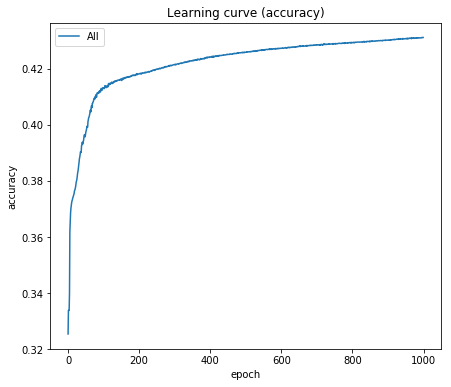

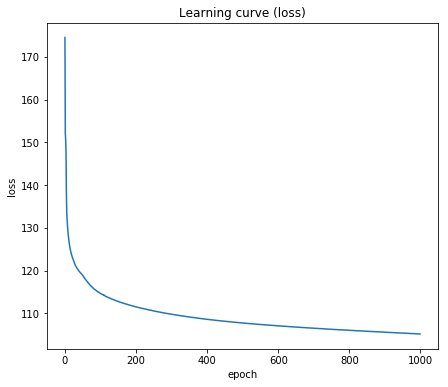

In [14]:
model_history.history.update({"dense_3_accuracy_0":model_history.history['dense_3_accuracy']})
print(model_history.history.keys())

sample_points = [2, 3, 4, 5 ]
plt.figure(figsize=(7,6))
accuracy_dense = []
for i in range(Ty):
    entry_name = 'dense_3_accuracy_%i' % i
    accuracy_dense.append(model_history.history[entry_name])
plt.plot(np.mean(accuracy_dense, axis=0), label='All')
#[plt.plot(model_history.history['dense_3_accuracy_%i' % i], label='y=%i'%i) for i in sample_points]
plt.title('Learning curve (accuracy)'); plt.legend()
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(model_history.history['loss'])
#plt.plot(model_history.history['val_loss'])
plt.title('Learning curve (loss)')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.show()

We'd also like to see how well our RNN is to predict new sentences. Here we input a new French sentence and let the RNN generates it translation. The result is compared to our own human translation through the Bleu score.

In [15]:
def sentence_to_ind(sent, T, lang_2_ind):
    tokens = tknzr.tokenize(sent.strip())
    inds = []
    for word in tokens:
        if word in lang_2_ind.keys():
            inds.append(lang_2_ind[word])
        else:
            inds.append(lang_2_ind['<unk>'])
    if len(inds) >= T:
        inds = inds[0:T]
    else:
        inds = inds + [lang_2_ind['<pad>']] * (T - len(inds))
    return inds

def log_bleu_score(y_true, y_pred):
    clip = 2; 

    y_depth = K.get_value(tf.shape(y_true))[0]
    pad_indx = [len(ind_2_en)-1 for i in range(y_depth)]
    anti_pad_vec = tf.one_hot(pad_indx, depth=len(ind_2_en), on_value=0, off_value=1)

    y_true = tf.cast( y_true, dtype=tf.int32)
    y_pred = tf.cast( y_pred, dtype=tf.int32)

    true_size = tf.math.reduce_sum(y_true*anti_pad_vec)
    pred_size =  tf.math.reduce_sum(y_pred*anti_pad_vec)
    
    log_BP_damped = lambda: tf.constant(1.) - tf.cast(true_size, dtype=tf.float32)/tf.cast(pred_size, dtype=tf.float32)
    log_BP_undamped = lambda: tf.constant(0.)
    
    log_BP =  tf.case([(tf.less(pred_size, true_size), log_BP_damped) ] , default=log_BP_undamped)
        
    y_match = tf.bitwise.bitwise_and(y_true, y_pred)*anti_pad_vec
    y_match_sum_copies = tf.reduce_sum(y_match, axis=0)
    y_match_sum_clipped = tf.clip_by_value(y_match_sum_copies , 0, clip)
    
    p = tf.reduce_sum(tf.cast(y_match_sum_clipped, dtype=tf.float32)/tf.cast(pred_size, dtype=tf.float32), axis=-1)

    return log_BP + tf.math.log(p)

In [16]:
new_sent = u"C'est une difficile probleme."
#new_sent = u"Bonjour, comment tu vas?"

tentative_trans = 'this is a difficult problem.'
source = sentence_to_ind(new_sent.encode('utf-8'), Tx, fr_2_ind)

attention_map = np.zeros((Ty, Tx))
source = np.array(list(map(lambda x: to_categorical(x, num_classes=fr_dict_size), source))) #.swapaxes(0,1)
source = np.reshape(source, (1,source.shape[0],source.shape[1]))
prediction = model.predict([source, s0, c0])
prediction = np.argmax(prediction, axis = -1)
output=[]
for i in prediction:
    if int(i) == en_2_ind['<pad>']:
        continue
    else:
        output.append(ind_2_en[int(i)])
        output.append(' ')
        
print("source:", new_sent)
print("output:", ''.join(output),"\n")

#attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, new_date, num = 7, n_s = 64);

pred_val = np.array(list(map(lambda x: to_categorical(x, num_classes=en_dict_size), prediction)))
pred_val = np.reshape(pred_val, (pred_val.shape[0], pred_val.shape[-1]))
true_val = sentence_to_ind(tentative_trans.encode('utf-8'), Ty, en_2_ind)
true_val = np.array(list(map(lambda x: to_categorical(x, num_classes=en_dict_size), true_val)))
bleu_result = log_bleu_score(tf.constant(true_val), tf.constant(pred_val))

print('(Log) Bleu score: %f (%f)' % (np.exp(bleu_result), bleu_result) )

source: C'est une difficile probleme.
output: it is is is the .  

(Log) Bleu score: 0.333333 (-1.098612)


### attention map

Look at the attention map. The attention map is a matrix showing that which part of the output sequence is paying the most attention on which part of the input sequence.

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


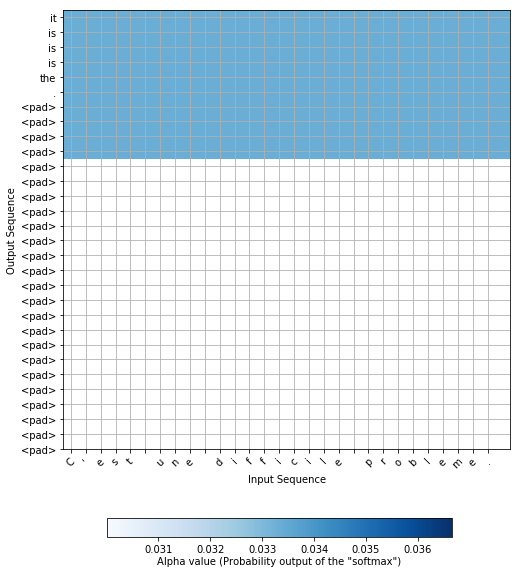

In [17]:
attention_layer = 7

attention_map = np.zeros((Ty, Tx))
    
s0 = np.zeros((1, n_s))
c0 = np.zeros((1, n_s))
layer = model.layers[attention_layer]

encoded = np.array(sentence_to_ind(new_sent, Tx, fr_2_ind)).reshape((1, Tx))
encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=fr_dict_size), encoded)))

f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
r = f([encoded, s0, c0])
    
for t in range(Ty):
    for t_prime in range(Tx):
        attention_map[t][t_prime] = r[t][0,t_prime,0]

#Normalize attention map
#row_max = attention_map.max(axis=1)
#attention_map = attention_map / row_max[:, None]

prediction = model.predict([encoded, s0, c0])
    
predicted_text = []
for i in range(len(prediction)):
    predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
predicted_text = list(predicted_text)
predicted_text = [ind_2_en[i] for i in predicted_text] 
    
input_length = len(new_sent)
output_length = Ty

# ------------------------- Plot --------------------------------

f = plt.figure(figsize=(8, 8.5))
ax = f.add_subplot(1, 1, 1)

show_size = 10
i = ax.imshow(attention_map[0:show_size][0:show_size], interpolation='nearest', cmap='Blues')

#cbaxes = f.add_axes([0.2, 0.25, 0.6, 0.03])
cbaxes = f.add_axes([0.2, 0.1-0.01*show_size, 0.6, 0.03])
cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

ax.set_yticks(range(output_length))
ax.set_yticklabels(predicted_text[:output_length])

ax.set_xticks(range(input_length))
ax.set_xticklabels(list(new_sent)[:input_length], rotation=45)

ax.set_xlabel('Input Sequence')
ax.set_ylabel('Output Sequence')

ax.grid()
f.show()

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

# Sequence sampling - synthesizing sentences

In this program, we will train a RNN to identify musics notes. The LSTM RNN is fed with a data set (X,Y), X being a Tx = 60 words sentence, and Y being a sequence of the same time-length Ty = Tx of all the possible words generated from the debate vocabulary. 

We subject it to a series of preprocessing as we have gone through in the previous section.

In [3]:
read_length = 4000; text_to_read = 'en' #(en or fr)
num_len = 3; first_file = 1; last_file = 243
file_char_encoding = 'cp1252'
len_cut = 30

train_set = 'training/hansard.36.1.house.debates.'
sentence_sample = np.random.randint(read_length)

current_len = 0
text = []

for file_no in range(first_file, last_file+1):
    text_suffix = "." + text_to_read[0]
    filename = data_dir + train_set + str(file_no).zfill(num_len) + text_suffix
    f = codecs.open(filename, "r", encoding=file_char_encoding)
    while True:
        line = f.readline()
        if (not line): break
        lang_line = (line.encode('utf-8')).strip().lower()
        #-----------------------------------------
        if (len(lang_line) < len_cut):
            continue
        if (lang_line[-1]==':'):
            continue
        if text_to_read == 'fr':
            if (lang_line[:2]=='* ') or (lang_line[:3]=='m. ') or (lang_line[:4]=='mme ') or (lang_line[:7]=='l\'hon. '):
                continue
        if text_to_read == 'en':
            if (lang_line[:2]=='* ') or (lang_line[:4]=='mr. ') or (lang_line[:4]=='ms. ') or (lang_line[:5]=='mrs. ')  or (lang_line[:5]=='hon. '):
                continue
        
        #-----------------------------------------
        text.append(lang_line)
        current_len = current_len + 1
        if current_len >= read_length:
            break
    f.close()
    if current_len >= read_length:
            break

print(text[sentence_sample])

there is no connection to the forces of innovation and change and reform that are at large in the country which if harnessed to national policy will help propel canada into the 21st century with vigour and optimism.


In [4]:
tokens = [];
for s in tqdm_notebook(text):
    tokens.append( tknzr.tokenize(s.strip()) )
    
del text;
    
print(tokens[sentence_sample])
print('\n')


[u'there', u'is', u'no', u'connection', u'to', u'the', u'forces', u'of', u'innovation', u'and', u'change', u'and', u'reform', u'that', u'are', u'at', u'large', u'in', u'the', u'country', u'which', u'if', u'harnessed', u'to', u'national', u'policy', u'will', u'help', u'propel', u'canada', u'into', u'the', u'21st', u'century', u'with', u'vigour', u'and', u'optimism', u'.']




In [5]:
def preprocess((sents, inds), lang_2_ind, Tx):
    T = Tx + 1
    X_inds = []; X_ohs = [];
    Y_inds = []; Y_ohs = [];
    i = 0;
    for sent in tqdm_notebook(sents):
        ind = inds[i]
        if len(sent) >= T:
            sent_redux = sent[0:T]
            ind_redux = ind[0:T]
        else:
            sent_redux = sent + ['<pad>'] * (T - len(sent))
            ind_redux = ind + [lang_2_ind['<pad>']] * (T - len(ind))
            
        X_ind = np.roll(ind_redux,1)[:-1] ;  X_ind[0] = 0; # lang_2_ind['<pad>'];
        Y_ind = ind_redux[:-1]
            
        X_oh = np.zeros((Tx, max(lang_2_ind.values())+1 ))
        X_oh[np.arange(Tx), X_ind] = 1
        Y_oh = np.zeros((Tx, max(lang_2_ind.values())+1 ))
        Y_oh[np.arange(Tx), Y_ind] = 1

        X_inds.append(X_ind); Y_inds.append(Y_ind)
        X_ohs.append(X_oh); Y_ohs.append(Y_oh)
        i = i + 1
        
    return np.array(X_inds), np.array(X_ohs), np.array(Y_inds), np.array(np.swapaxes(Y_ohs,0,1))

In [6]:
Tx = 60

lang_2_ind, ind_2_lang, indices = text_to_indices(tokens, cutoff_for_rare_words=1)

indices_values = ind_2_lang
n_vocabs = len(ind_2_lang)

_, X, _, Y = preprocess((tokens, indices), lang_2_ind, Tx)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_vocabs)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)


number of training examples: 4000
Tx (length of sequence): 60
total # of unique values: 3694
shape of X: (4000, 60, 3694)
Shape of Y: (60, 4000, 3694)


## Model

The model is a simple LSTM that output the an equal length sequence. It consists of a LSTM chain, and top of each LSTM block, a fully-connected layer with softmax activation to process the LSTM output.

In [7]:
n_a = 64 # number of dimensions for the hidden state of each LSTM cell.
n_values = X.shape[2] # number of music values
m = X.shape[0]
reshaper = Reshape((1, n_values)) 
LSTM_cell = LSTM(n_a, return_state = True)
FC = Dense(n_values, activation='softmax') 


def sent_model(Tx, n_a, n_values):

    #Arguments:
    #Tx -- length of the sequence in a corpus
    #n_a -- the number of activations used in our model
    #n_values -- number of unique values in the music data 
    
    #Returns:
    #model -- a keras instance model with n_a activations
    
   
    X = Input(shape=(Tx, n_values))
    
    
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
   
    outputs = []
    
    for t in range(Tx):
        
        x = Lambda(lambda X: X[:,t,:])(X)
        x = reshaper(x)
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        out = FC(a)
        outputs.append(out)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    
    return model

Compile the model.

In [8]:
model = sent_model(Tx = Tx , n_a = n_a, n_values = n_values)
model.summary()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 3694)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 3694)         0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 3694)      0           lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
                                                                 lambda_4[0][0]             

Fit the model to the data (X,Y).

In [ ]:
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

model_history_2 = model.fit([X, a0, c0], list(Y), epochs=100)

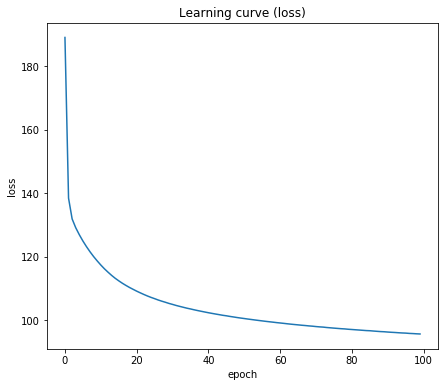

In [10]:
plt.figure(figsize=(7,6))
plt.plot(model_history_2.history['loss'])
plt.title('Learning curve (loss)')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.show()

Again we subject the network to a sentence and let it predicts the next word for every previous word in a sentence. Then, we let Bleu score to judge the accuracy of the prediction.

In [11]:
def bleu_score(reference, hypothesis, lang_2_ind):
    reference_no_pad = (reference[reference !=lang_2_ind['<pad>']]).tolist()
    hypothesis_no_pad = (hypothesis[hypothesis != lang_2_ind['<pad>']]).tolist()
    print('reference: ', reference_no_pad)
    print('hypothesis: ', hypothesis_no_pad)
    return nltk.translate.bleu_score.sentence_bleu([reference_no_pad], hypothesis_no_pad)

def sentence_to_ind(sent, T, lang_2_ind):
    tokens = tknzr.tokenize(sent.strip())
    inds = []
    for word in tokens:
        if word in lang_2_ind.keys():
            inds.append(lang_2_ind[word])
        else:
            inds.append(lang_2_ind['<unk>'])
    if len(inds) >= T:
        inds = inds[0:T]
    else:
        inds = inds + [lang_2_ind['<pad>']] * (T - len(inds))
    return inds

In [80]:
new_sent = u"this is the most difficult problem the people has to tackle."
source = sentence_to_ind(new_sent.encode('utf-8'), Tx, lang_2_ind)

source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(lang_2_ind)), source))) 
source = np.reshape(source, (1, source.shape[0],source.shape[1]))
true_val_oh = source[0][1:]
true_val = np.argmax(true_val_oh, axis = -1)

s0 = np.zeros((1, n_a))
c0 = np.zeros((1, n_a))

prediction = model.predict([source, s0, c0])
prediction = np.argmax(prediction, axis = -1)
output=[]; truth=[];
for i in prediction:
    if int(i) == lang_2_ind['<pad>']:
        continue
    else:
        output.append(ind_2_lang[int(i)])
        output.append(' ')
        
for i in true_val:
    if int(i) == lang_2_ind['<pad>']:
        continue
    else:
        truth.append(ind_2_lang[int(i)])
        truth.append(' ')
        
print("source:", ''.join(truth),"\n")
print("output:", ''.join(output),"\n")

pred_val = np.swapaxes(prediction, 1, 0)[0]
bleu_result = bleu_score(true_val, pred_val, lang_2_ind)

print('Bleu score (log): %f (%f) \n' % (bleu_result, np.log10(bleu_result)) )

source: is the most difficult problem the people has to tackle .  

output: is the government of of of government of the the .  

reference:  [10, 1, 162, 981, 319, 1, 36, 29, 3, 2079, 2]
hypothesis:  [10, 1, 18, 4, 4, 4, 18, 4, 1, 1, 2]
Bleu score (log): 0.000000 (-154.186161) 



## Sequence sampling from the model

Now we have trained an RNN model to identify music sequence. We can sample the sequence by fitting the RNN output to itself. To be precise, for a LSTM block at t, we fit the output of the LSTM block at t-1, y(t-1), to its input x(t), and we append the output y(t) to our generated sequence. This way we can endlessly synthesize a new sequence from a trained model and some random intial (t=0) input.

Note that we have used the globally defined _LSTM&#95;cell_ and _FC_ in the layer variables. This allowed us to extract the model parameters we trained in the previous section.

In [12]:
def one_hot(x):
    x = K.argmax(x)
    x = tf.one_hot(x, n_vocabs) 
    x = RepeatVector(1)(x)
    return x

def sent_inference_model(LSTM_cell, densor, n_values = n_vocabs, n_a = 64, Ty = 100):
    
    #Arguments:
    #LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    #FC -- the trained dense layer from model(), Keras layer object
    #n_values -- integer, number of unique values
    #n_a -- number of units in the LSTM_cell
    #Ty -- integer, number of time steps to generate
    
    #Returns:
    #inference_model -- Keras model instance

    x0 = Input(shape=(1, n_values))
   
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    outputs = []
    
    for t in range(Ty):
        
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        out = FC(a)
        outputs.append(out)
        x = Lambda(lambda x: one_hot(x))(out)
        
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    
    return inference_model

In [13]:
inference_model = sent_inference_model(LSTM_cell, FC, n_values = n_vocabs, n_a = n_a, Ty = 100)

inference_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 3694)      0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  962304      input_2[0][0]                    
                                                                 a0[0][0]                   

Predict the sequence from our inference model. And then display the sampled sentence. We allow 3 types of initialization of the sequence sampling. First, a null initialization with a null vector. Second, Initializing with a random word in the dictionary. Third, a word that we selects.

In [14]:
initalizer = ''

x_initializer = np.zeros((1, 1, n_vocabs))
if not initalizer:
    print('NULL initialization')
elif initalizer == 'RAND':
    rand_word = np.random.randint(n_vocabs)
    x_initializer[0][0][rand_word] = 1
    print("initialize word :", ind_2_lang[rand_word])
else:
    if initalizer in lang_2_ind.keys():
        initializer_indx = lang_2_ind[initalizer]
    else:
        initializer_indx = lang_2_ind['<unk>']
    x_initializer[0][0][initializer_indx] = 1
    print("initialize word :", ind_2_lang[initializer_indx])

NULL initialization


In [15]:
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
indices_return = np.argmax(pred, axis=-1)
results_return = to_categorical(indices_return, num_classes=x_initializer.shape[-1])



output = []
for i_ret in indices_return:
    if int(i_ret[0]) == lang_2_ind['<pad>']:
        continue
    else:
        output.append(ind_2_lang[int(i_ret[0])])
        output.append(' ')

print("Sequence sampled :\n", ''.join(output),"\n")

Sequence sampled :
 i am very very very important for the house of the government has been a <unk> <unk> , <unk> <unk> , <unk> , <unk> , and <unk> , the government will be <unk> to the <unk> of the <unk> of the world .  

